$\Huge Internal$ $\hspace{0.1cm}$ $\Huge Linear$ $\hspace{0.1cm}$ $\Huge Combination$ $\hspace{0.1cm}$ $\Huge (ILC)$ $\hspace{0.1cm}$  $\Huge code$ $\hspace{0.1cm}$ $\Huge :$ 

# TO DO :

1. Clean the code 
2. Implement the conversion factor
3. Put everything into one ILC function

# Modules : 

In [98]:
from astropy.io import fits
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt 
import math as m 
import decimal
from scipy.interpolate import interp1d
from scipy.integrate import quad
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True)
from astropy.cosmology import FlatLambdaCDM
from astropy import constants as cst
import fbasic as f
from scipy.ndimage import gaussian_filter

# Physics :

In [99]:
cosmo = FlatLambdaCDM(H0=70, Om0=0.3, Tcmb0=2.7255)
T_CMB = cosmo.Tcmb0.si.value
k_B = cst.k_B.value
h = cst.h.value
c = cst.c.value
sig_T = cst.sigma_T.value #Thomson cross section in m2 
me = cst.m_e.value #Electron mass in kg 
Te = 5.930155e9 #Electron temperature in K

In [3]:
#Dictonary containing the transmission values assiociated to the center of each filter :
dic_tr = {'1':0.540426915616,'2':0.744680862234,'3':0.859606923654,'4':0.912870060983,'5':0.667626775271,'6':0.899234489388}
inter_cov=0 #Used to compute the covariance later
flat_cov=[] #Array inside of with we are going to put the values of the covariance 
mix_vect=[] 
mix_vect2=[] 
ILC_weight=[]
L=[0,0,0,0,0,0]
M=[0,0,0,0,0,0]
I_0 = (2*(k_B*T_CMB)**3)/(h*c)**2
sum_I = 0
Li=[]
sum_2 = 0
L2=[]
nu_c={0:100,1:143,2:217,3:353,4:545,5:847}

In [4]:
data_path = '/vol/aibn1118/data1/mcharmetant/Data/Planck_AllSky_maps/' #Path were the data are stored
freq_unit = 'GHz' #Unit of the frequencies used
dic_freq = {0:'100',1:'143',2:'217',3:'353',4:'545',5:'857'}#Dictonary with all the frequencies for Planck
maps_unit = 'MJy/sr' #Units of the maps
data_origin = 'Planck AllSKy DR2' #Name of the data used
pictures_path = '/users/mcharmetant/Desktop/Pictures/' #Path where the pictures are stored 

NameError: name 'name_object' is not defined

## Inputs :

### To modify :

In [119]:
#A2319 Cluster : 
#name_object = 'A2319Cluster' #Name of the Object around which the cutout is make 
#name_file = 'cutout_smooth_A2319Cluster_' 
#maps_name = 'stacked_A2319Cluster.fits' #File containing all the smooth maps for all frequencies. 

#Perseus Cluster : 
#name_object = 'PerseusCluster' #Name of the Object around which the cutout is make 
#name_file = 'cutout_smooth_PerseusCluster_' 
#maps_name = 'stacked_PerseusCluster.fits' #File containing all the smooth maps for all frequencies. 

#Coma Cluster : 
#name_object = 'ComaCluster' #Name of the Object around which the cutout is make 
#name_file = 'cutout_smooth_ComaCluster_' 
#maps_name = 'stacked_ComaCluster.fits' #File containing qll the smooth maps for all frequencies. 

### To compute : 

smooth all the maps to the same resolution and merge them into an array 

In [105]:
def smooth_map_gaussian(data_path,file_in_p1,file_in_p2,dic_reso,dic_freq,pixel_size,wt_reso,data,j):
    
    """
    Function which smooth CMB map to a given resolution

    Parameters
    ----------
    dic_reso : dict
        Dictonary containing all the resolutions for each bandpass. 
    dic_freq : dict
        Dictonary containing all the frequencies we want to deal with for those peculiar data. 
    pixel_size : float
        Size of a pixel for the maps 
    wt_reso : float
        Resolution to which we want to tranform the maps.  
    Returns
    -------
    str
        Tell us where the function stored the datas and images. 

    """
    
    for i in range(0,len(dic_freq)): #Itteration on the dictonary to print all the CMB maps at their frequency
        
        file = data_path + file_in_p1 + str(dic_freq[i]) + file_in_p2
        hdul = fits.open(file)
        maps = hdul[j].data
            
        #Compute the sigma of the Gaussian : 
        FWHM_i = m.sqrt(wt_reso**2 - dic_reso[i]**2) 
        FWHM_f = FWHM_i/pixel_size
        sig = FWHM_f/(2*m.sqrt(np.log(2)))
    
        #Smoothing by a Gaussian and save data in FITS file: 
        smooth_map = gaussian_filter(maps,sigma=sig,truncate=10) #Apply a Gaussian filter to smooth the maps 
        #The value truncate = 10 as been chosen for consistency with Jens and others.. 
        
        smooth_map = smooth_map.flatten()
        
        if i==0: 
            
            stacked = [smooth_map]
            
        else: 
            
            stacked = np.concatenate((stacked,[smooth_map]),axis=0)

    return stacked
    

We know that the energy of and electron is $E_{e}=511$ keV, we want to convert that into Kelvins units for homogeneity. In order to do that we are going to use Boltzmann constant. We have that : 

$\frac{1 eV}{k_{B}}=\frac{1.6022\times 10^{-19} J}{1.38064852\times 10^{-23} JK^{-1}}=11605 K$

donc $511 keV = 511\times 11605\times 10^{3} = 5930155\times 10^{3} K = 5.930155 \times 10^{9} K$

## Code : 

###### Computation of the covariance matrix : 

To compute the covariance matrix of the map $T_{i}$, where $i\in [100,143,217,353,545,857]$ GHz which are Planck HFI frequencies. We use : 

$C_{i,j}=COV(T_{i},T_{j})=\frac{1}{N_{pix}}\sum _{p=1}^{N_{pix}}(T_{i}(p)-\langle T_{i}\rangle)(T_{j}(p)-\langle T_{j}\rangle)$

Where $N_{pix}$ is the number of pixel in a map $T_{i}$. 

In [101]:
def covcorr_matrix(data):
    
    """
    Function which compute the covariance matrix.  

    Parameters
    ----------
    
    data : array
        Array containing the maps we want to get the covariance off.  
        
    Returns
    -------
    tuple
        containing [0] : the covariance matrix [1] : the correlation matrix

    """
    
    #Compute and save as FITS file the covariance matrix : 
    cov_matrix = np.cov(data,rowvar=True) #Compute the covariance matrix 
    corr_matrix = np.corrcoef(data, y=None, rowvar=True)
    
    return (cov_matrix,corr_matrix)

###### Computation of tSZ spetrum and the mixing vector  for Intensity maps : 

We want to diplay tSZ, we have : 

$\Delta I_{tSZ}=I_{0}yf(x(\nu))h(x(\nu))=I_{0}y\frac{x(\nu)^{4}e ^{x(\nu)}}{(e^{x(\nu)}-1)^{2}}(x(\nu)\frac{e^{x(\nu)}+1}{e^{x(\nu)}-1}-4)$    with $x(\nu)=\frac{h\nu}{k_{B}T_{CMB}}$ and $y=\frac{\sigma _{T}}{m_{e}c^{2}}\int P_{e}dl$ where $P_{e}=n_{e}k_{B}T_{e}$

In the first approximation we can put $y=1$.

Then, we want to cumpute the mixing vector. In the first approximation we can consider that the mixing vector is only compose of the values of $\Delta I_{tSZ}$ for each of the Planck HFI frequencies : $[100,143,217,353,545,857]$ GHz. Multiply by the transmission of each filter at the values of Planck HFI frequencies. 

In [16]:
def D_I_tSZ(x,y):
    
    """
    Function which compute the tSZ spectral shape. 

    Parameters
    ----------
    
    x : array
        Frequency range over which the tSZ spectral shape will be computed. 
    y : float
        Value of the Compton-y parameter assumed here. 
        
    Returns
    -------
    array
        Array contaning the Variarion of intensity produced by tSZ over the fequencies. 

    """
    
    #Compute Delta I : 
    I_0 = (2*(cst.k_B.value*T_CMB)**3)/(cst.h.value*cst.c.value)**2    
    x_nu = np.array((cst.h.value*x)/(cst.k_B.value*T_CMB))    
    Delta_I = np.array(I_0*y*(x_nu**4)*(np.exp(x_nu)/(np.exp(x_nu)-1)**2)*((x_nu*(np.exp(x_nu)+1)/(np.exp(x_nu)-1))-4))
    
    #Give feedback to the operator : 
    print("Delta I as been computed ")
    
    return   Delta_I

In [17]:
def mixing_vector(dic_freq):
    
    """
    Function which compute the multiplying vector to transform a y-map into a tSZ(f). 

    Parameters
    ----------
    
    dic_freq : dic
        Dictonary containing the frequencies we want to get a tSZ map of. 
    pictures_path : str 
        Path under which the picture will be saved
    name_save : str 
        Name under which the picture will be saved. 
        
    Returns
    -------
    array
        Array contaning the multiplying vector. 

    """       
    
    #Initilisation : 
    freq = np.arange(0,1000)*10**9  
    mix_vect = []
    
    # Compute the spectral shape of tSZ : 
    Delta_I = D_I_tSZ(freq,1)

    #For each frequency channel, compute Delta_I : 
    for i in range(len(dic_freq)):
        
        mix_vect.append(Delta_I[dic_freq[i]]*(10**20))
        
    #Give feeback to the operator :    
    print('The mixing vector is : ',mix_vect)

    return mix_vect

###### Computation of the ILC weights  and y map : 

In [46]:
def ILC_weights(mix_vect,cov_matrix,data):   
    
        
    """
    Function which compute the weights used by the ILC and do the ILC.

    Parameters
    ----------    
    mix_vect : list 
        List containing all the values of the mixing vector. 
    cov_matrix : array 
        Array containing the covariance matrix 
    data : array 
        array containing the different frequencies maps. 
    
    Returns
    -------
    array
        Cotaining the Compton-y map. 

    """
    
    #Compute the weight of the ILC : 
    inv_cov = np.linalg.inv(cov_matrix) #Take the inverse of the covariance matrix. 
    ILC_weight = (inv_cov @ mix_vect) / (np.transpose(mix_vect) @ inv_cov @ mix_vect) #Compute the weights
    print('ILC weights are : ',ILC_weight)
    y=0  # Initialisation of the y map. 
    
    #Compute y map : 
    for i in range(0,len(mix_vect)): #Go through all the frequencies.
        map_Ti = data[i]
        y = y + ILC_weight[i] * map_Ti        
    y_map = np.reshape(y,(200,200)) #Reshape the maps which were (40000,6) to compute the covariance, but they need to be 200x200 to be displayed
    
    return y_map

# Test for Coma cluster : 

## array of the frequency maps : 

In [113]:
smoothed_map = smooth_map_gaussian(data_path=data_path,file_in_p1='Cutout_ComaCluster_',file_in_p2='GHz.fits',
                                   dic_reso={0:9.66, 1:7.27, 2:5.01, 3:4.86, 4:4.84, 5:4.63},
                    dic_freq=dic_freq,pixel_size=1.55,wt_reso=9.66,
                    data=stacked_maps,j=0)

## Compute covariance matrix :

In [107]:
covcorr = covcorr_matrix(data=smoothed_map)

/users/mcharmetant/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


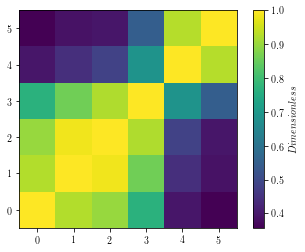

In [108]:
plt.imshow(covcorr[1], origin='lower')
plt.colorbar(label='$Dimensionless$')
plt.show()

## Compute mixing vector : 

In [109]:
mix = mixing_vector(dic_freq={0:100,1:143,2:217,3:353,4:545,5:857})

Delta I as been computed 
The mixing vector is :  [-981.5135137428723, -1077.3001172255508, -10.24749116173733, 1811.6920865357347, 871.4562130949258, 43.39822093413915]


/users/mcharmetant/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:24: RuntimeWarning: divide by zero encountered in true_divide
/users/mcharmetant/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in multiply
/users/mcharmetant/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in true_divide


## Apply ILC on the set of maps : 

In [110]:
y_map = ILC_weights(mix_vect=mix,cov_matrix=covcorr[0],data=smoothed_map)

ILC weights are :  [ 1.70235710e-05 -2.18342869e-04 -1.19794548e-04  5.31763323e-04
 -2.11889947e-04  3.50678197e-05]


/users/mcharmetant/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


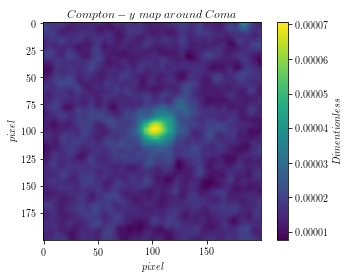

In [111]:
fig, ax = plt.subplots()
im = ax.imshow(y_map, cmap='viridis')
fig.colorbar(im, orientation='vertical',label='$Dimentionless$')
ax.set_xlabel('$pixel$')
ax.set_ylabel('$pixel$')
ax.set_title('$Compton-y$ $map$ $around$ $Coma$')       
ax.imshow(y_map)

# For perseus cluster : 

In [114]:
smoothed_map_Perseus = smooth_map_gaussian(data_path=data_path,file_in_p1='Cutout_PerseusCluster_',file_in_p2='GHz.fits',
                                   dic_reso={0:9.66, 1:7.27, 2:5.01, 3:4.86, 4:4.84, 5:4.63},
                    dic_freq=dic_freq,pixel_size=1.55,wt_reso=9.66,
                    data=stacked_maps,j=0)

In [115]:
covcorr_Perseus = covcorr_matrix(data=smoothed_map_Perseus)

/users/mcharmetant/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


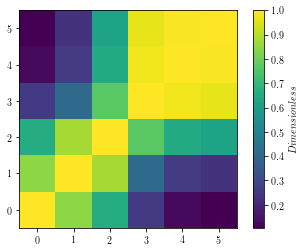

In [116]:
plt.imshow(covcorr_Perseus[1], origin='lower')
plt.colorbar(label='$Dimensionless$')
plt.show()

In [118]:
y_map_Perseus = ILC_weights(mix_vect=mix,cov_matrix=covcorr_Perseus[0],data=smoothed_map_Perseus)

ILC weights are :  [ 3.81409742e-05 -3.85567803e-04  3.44585831e-05  4.56535263e-04
 -2.36666038e-04  3.59351601e-05]


/users/mcharmetant/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


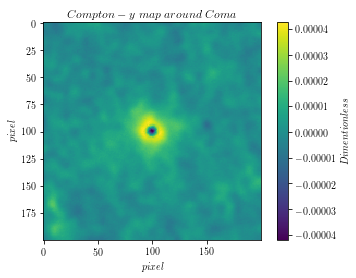

In [119]:
fig, ax = plt.subplots()
im = ax.imshow(y_map_Perseus, cmap='viridis')
fig.colorbar(im, orientation='vertical',label='$Dimentionless$')
ax.set_xlabel('$pixel$')
ax.set_ylabel('$pixel$')
ax.set_title('$Compton-y$ $map$ $around$ $Coma$')       
ax.imshow(y_map)